# Boundary mapping

The purpose of this notebook is to mess around with all the different options available with boundary mapping

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('..', 'hypedsearch', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)


import database
import testing_utils
import operator
import collections


#Assumptions:
max_peptide_length = 20
ppm_tolerance = 20

import matplotlib.pyplot as plt

In [2]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = dataset[0]
input_spectra, boundaries = testing_utils.preprocess_input_spectra(input_spectra_path, ppm_tolerance)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path)

Loading spectra...
Done


In [3]:
matched_masses_b, matched_masses_y, database = testing_utils.modified_match_masses(boundaries, db, max_peptide_length)
# matched_masses_b, matched_masses_y, database = match_masses(boundaries, db, max_peptide_length)
print('Finished matching masses')

On protein 279/279 [100%]
Sorting the set of protein masses...
Sorting the set of protein masses done
Performing Merge
Done
Finished matching masses


# Grabbing hits

In [4]:
spectrum_num = 0
correct_sequence = correct_sequences[spectrum_num]
print(correct_sequence)

input_spectrum = input_spectra[spectrum_num]

#Remember to add in abundance if it is helpful
b_hits, y_hits, b_set, y_set, misses = testing_utils.find_hits(boundaries, input_spectrum, spectrum_num, matched_masses_b, matched_masses_y)
correct_hits = testing_utils.append_correct_hits(correct_sequence, input_spectrum, ppm_tolerance)

DPQVEQLEL


# Writing hits

In [5]:
testing_utils.write_hits(b_hits, y_hits)

Done


In [59]:
import utils

def parse_indices(index_set):
    indices = []
    for index in index_set:
        string = str(index)
        A = string.rstrip().split(',')
        start = A[0]
        end = A[1]
        seq = A[2]
        mz = A[3]
        disallowed_characters = " ()\'"
        for character in disallowed_characters:
            start = start.replace(character, "")
            end = end.replace(character, "")
            seq = seq.replace(character, "")
            mz = mz.replace(character, "")
        
        target_tuple = (int(start), int(end), seq, float(mz))
        indices.append(target_tuple)
    
    
    return indices

def calc_weighted_sum(indices, boundaries, matched_masses):
    total_sum = 0
    for subCluster in indices:
        mass = subCluster[3]
        boundary = boundaries[mass]
        boundary = utils.hashable_boundaries(boundary)
        if len(matched_masses[boundary]) != 0:
            total_sum = total_sum + (1/ len(matched_masses[boundary]) ) + set_prior(mass, boundaries, matched_masses)
        else:
            total_sum = total_sum
    return total_sum

# weighted_sum_array = []
# score_array = []
# for cluster in b_sorted_clusters:
#     indices = parse_indices(cluster)
#     weighted_sum_array.append(calc_weighted_sum(indices, matched_masses_b))
#     score_array.append(cluster.score)
# for cluster in y_sorted_clusters:
#     indices = parse_indices(cluster)
#     weighted_sum_array.append(calc_weighted_sum(indices, matched_masses_y))
#     score_array.append(cluster.score)
    
# def create_tuple_from_element(A):
#     start = A[0]
#     second = A[1]
#     seq = A[2]
#     mass = A[3]
#     disallowed_characters = " ()\'"
#     for character in disallowed_characters:
#         start = start.replace(character, "")
#         seq = seq.replace(character, "")
#         mass = mass.replace(character, "")
#     start = int(start)
#     second = int(second)
#     mass = float(mass)
    
#     target_tuple = (start, second, seq, mass)
#     return target_tuple

# def calc_post_prob(indices, ion, boundaries, matched_masses_b, matched_masses_y):
#     post_prob_array = []
#     post_prob = 0
#     for element in indices:
#         A = element.split(',')
#         A = create_tuple_from_element(A)
#         seq = A[2]
#         mz = A[3]
#         b = boundaries[mz]
#         b = utils.hashable_boundaries(b)
#         that_prior = set_prior(mz, ion, boundaries, matched_masses_b, matched_masses_y)
#         if ion == 'b':
#             that_post_prob =  1/len(seq) * that_prior
#         else:
#             that_post_prob =  1/len(seq) * that_prior
#         post_prob_array.append(that_post_prob)
#     for prob in post_prob_array:
#         post_prob = post_prob + prob
        
#     return post_prob
    
    
def set_prior(mz, boundaries, matched_masses):
    # for i in range (0, len(b_sorted_clusters)):
    # prior = 1 / # of occurances
    b = boundaries[mz]
    b = utils.hashable_boundaries(b)
    P_A = 1/len(matched_masses[b])    
    return P_A

# def calc_post_prob(prior, indices):
#     #Should calculate it's own posterior and add to each posterior in indices
#     post = 0
#     for element in indices:
#         A = element.rstrip().split(',')
#         string = A[2]
#         mz = (A[3])
#         mz = mz[:-1]
#         mz = mz[2:]
#         that_prior
#         post = post + (1/len(string) * that)
#     return post

def sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y):
    cluster = collections.namedtuple('cluster', 'post_prob prior score pid start end seq mz indices')
    if ion == 'b':
        b_cluster_array = []
        with open('clusters.txt', 'r') as c:
            for line in c:
                A = line.rstrip().split('\t')
                score = int(A[0])
                pid = int(A[1])
                seq = A[2]
                mz = float(A[3])
                start = int(A[4])
                end = int(A[5])
                indices = []
                [indices.append(A[x]) for x in range(6,len(A))]
                prior = set_prior(mz, boundaries, matched_masses_b)
                indices = parse_indices(indices)
                post_prob = score + calc_weighted_sum(indices, boundaries, matched_masses_b)

                b_cluster_array.append(cluster(post_prob=post_prob, prior=prior, score=score, pid=pid, start=start, end=end, seq=seq, mz=mz, indices=indices) )

        b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
        return b_sorted_clusters
    else:
        y_cluster_array = []
        with open('clusters.txt', 'r') as c:
            for line in c:
                A = line.rstrip().split('\t')
                score = int(A[0])
                pid = int(A[1])
                seq = A[2]
                mz = float(A[3])
                start = int(A[4])
                end = int(A[5])
                indices = []
                [indices.append(A[x]) for x in range(6,len(A))]
                prior = set_prior(mz, boundaries, matched_masses_y)
                indices = parse_indices(indices)
                post_prob = score + calc_weighted_sum(indices, boundaries, matched_masses_b)

                y_cluster_array.append(cluster(post_prob=post_prob, prior=prior, score=score, pid=pid, start=start, end=end, seq=seq, mz=mz, indices=indices) )

        y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
        return y_sorted_clusters

# Clustering b hits

In [60]:
ion = 'b'
testing_utils.create_clusters(ion)
b_sorted_clusters = sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

# Printing data

In [61]:
# b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
testing_utils.write_b_sorted_cluster(b_sorted_clusters)
for i in range(0, 50):
    x = b_sorted_clusters[i]
    post_prob = x.post_prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

7.052751162968867 7 DPQVEQLE
4.0337230490073495 4 DPEVQQI
4.033024152288204 4 PDAGAPTSASGLSGHTTL
4.032008697586215 4 HSLMPMLE
4.028463692255176 4 GTYFEVKIPSDTFYDN
4.026701333923687 4 TVFSDFL
4.016716274959339 4 PAGDQKDV
4.013887637480725 4 TQAGVEELDPENKIP
3.031340536792882 3 TPPPAGEAAF
3.0286654946191485 3 TSFLVNRDH
3.0282134071340714 3 LNCHTQ
3.0282134071340714 3 PSPSEAQ
3.0282134071340714 3 YYEIQ
3.0282134071340714 3 QAGPGASQ
3.0282134071340714 3 EDNLPQ
3.0282134071340714 3 YYEIQ
3.027641420482896 3 TLSFSSIS
3.0264990557129368 3 HTDTNKIE
3.0264990557129368 3 IQEYYNK
3.0264990557129368 3 REENAPKN
3.0263429752066116 3 IYEGYAL
3.0263429752066116 3 IYEGYAL
3.0263429752066116 3 HCQQLSI
3.0263429752066116 3 IYEGYAL
3.0263429752066116 3 HLTDTEI
3.0263429752066116 3 SHANTWL
3.0233941527955612 3 QPARED
3.022797969875573 3 YALYDA
3.022797969875573 3 YANNHP
3.022797969875573 3 GQPADDI
3.0226947394121737 3 TTFV
3.0226947394121737 3 TTFV
3.0214434204339087 3 PGGEEVLREQAGGD
3.021191692050409 3 TSY

# Clustering y_hits

In [62]:
ion = 'y'
testing_utils.create_clusters(ion)
y_sorted_clusters = sort_clusters_by_post_prob(ion, boundaries, matched_masses_b, matched_masses_y)

# Printing data

In [63]:
# y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
for i in range(0, 50):
    x = y_sorted_clusters[i]
    post_prob = x.post_prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

5.051659430902814 5 LDSFSEI
4.051659430902814 4 LESYGLE
4.046149789029536 4 CGLYEL
4.046149789029536 4 HPDSEL
4.032008697586215 4 EISSIDEF
4.032008697586215 4 EIPHSELD
4.030767753967673 4 FVDLTMPYSV
4.028463692255176 4 SSNWVGKGFFAVYEAIC
3.034245027124774 3 EGEDDRTVCKEI
3.0326965294969406 3 YENLNDQEL
3.0326965294969406 3 IMTERDMEL
3.0326965294969406 3 LRSSSCGDAEL
3.0326965294969406 3 LYENLDEEL
3.031917115762209 3 PENPEI
3.031917115762209 3 EKYKNIDEDEL
3.0316455696202533 3 DPQVEQLEL
3.0316455696202533 3 HGEIIYPEI
3.031216160710952 3 SDIAMTEL
3.031216160710952 3 TEEKMEL
3.030982178075806 3 SDNAPPPEL
3.030982178075806 3 YNYVWANCFEITLEL
3.030982178075806 3 PIDHLCEL
3.0308260975694807 3 TAEIASLDSENIDEI
3.0308260975694807 3 ESYGLEL
3.0308260975694807 3 HWEPEI
3.0308260975694807 3 SFSEVEL
3.0308260975694807 3 LEDSDLKKSDIDEI
3.0308260975694807 3 YFEEYGKIDTIEI
3.0308260975694807 3 YGDLTEI
3.0308260975694807 3 FSESVEL
3.030621495484001 3 GYISAAEL
3.030621495484001 3 YQASLEL
3.0300445880839093 3 A

# Plotting

In [64]:
from scoring import mass_comparisons
import gen_spectra
print("Collecting data...")
score_array = []
posterior_array = []
bscore_array = []
for cluster in b_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='b')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
for cluster in y_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='y')))
    posterior_array.append(cluster.post_prob)
    bscore_array.append(cluster.score)
print("Done")


Done


Text(0.5, 1.0, 'Posterior probability vs Simple additive scoring')

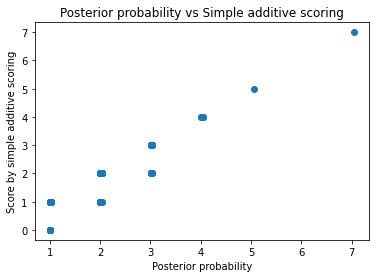

In [65]:
plt.scatter(posterior_array, score_array, s=None)
plt.ylabel('Score by simple additive scoring')
plt.xlabel('Posterior probability')
plt.title("Posterior probability vs Simple additive scoring")

Text(0.5, 1.0, 'Posterior probability vs cluster scoring')

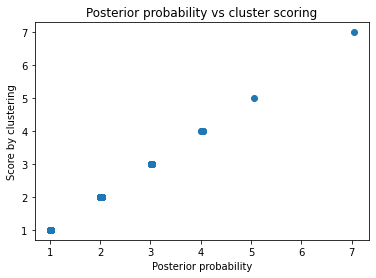

In [66]:
plt.scatter(posterior_array, bscore_array, s=None)
plt.xlabel("Posterior probability")
plt.ylabel("Score by clustering")
plt.title("Posterior probability vs cluster scoring")

# Prior vs Scoring

In [67]:
prior_array = []
Likelihood_array = []
score_array = []
for cluster in b_sorted_clusters:
    prior_array.append(cluster.prior)
    Likelihood_array.append((1/len(cluster.seq)))
    score_array.append(cluster.score)
for cluster in y_sorted_clusters:
    prior_array.append(cluster.prior)
    Likelihood_array.append((1/len(cluster.seq)))
    score_array.append(cluster.score)
print("Done")

Done


Text(0.5, 1.0, 'Prior probability vs cluster scoring')

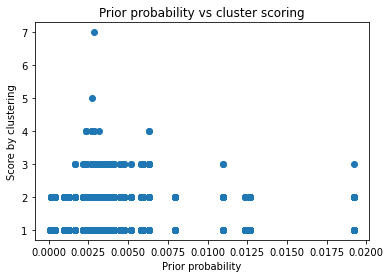

In [68]:
plt.scatter(prior_array, score_array, s=None)
plt.xlabel("Prior probability")
plt.ylabel("Score by clustering")
plt.title("Prior probability vs cluster scoring")

Text(0.5, 1.0, 'Likelihood vs cluster scoring')

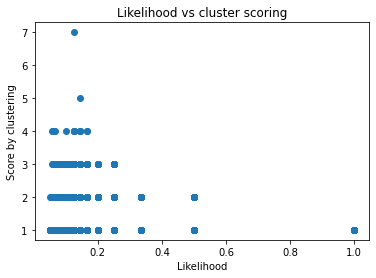

In [69]:
plt.scatter(Likelihood_array, score_array, s=None)
plt.xlabel("Likelihood")
plt.ylabel("Score by clustering")
plt.title("Likelihood vs cluster scoring")

# Weighted Sum vs Scoring

In [70]:
weighted_sum_array = []
score_array = []
for cluster in b_sorted_clusters:
    weighted_sum_array.append(calc_weighted_sum(cluster.indices, boundaries, matched_masses_b))
    score_array.append(cluster.score)
for cluster in y_sorted_clusters:
    weighted_sum_array.append(calc_weighted_sum(cluster.indices, boundaries, matched_masses_y))
    score_array.append(cluster.score)

Text(0.5, 1.0, 'Weighted sum vs cluster scoring')

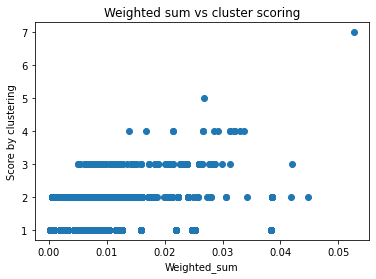

In [71]:
plt.scatter(weighted_sum_array, score_array, s=None)
plt.xlabel("Weighted_sum")
plt.ylabel("Score by clustering")
plt.title("Weighted sum vs cluster scoring")

# Probability of true positives

In [72]:
def calc_average(list):
    total = 0
    for x in list:
        total = total + x
    return total / len(list)

In [73]:
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)


b_post_prob_array = []
b_score_array = []
y_post_prob_array = []
y_score_array = []
bad_clusters_prob = []
bad_clusters_score = []
for cluster in b_sorted_clusters:
    ion = 'b'
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_post_prob_array.append(cluster.post_prob)
        b_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.post_prob)
        bad_clusters_score.append(cluster.score)
for cluster in y_sorted_clusters:
    ion = 'y'
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_post_prob_array.append(cluster.post_prob)
        y_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.post_prob)
        bad_clusters_score.append(cluster.score)   

b_range = []
y_range = []
for i, x in enumerate(b_post_prob_array):
    b_range.append(i)
for i, x in enumerate(y_post_prob_array):
    y_range.append(i)
print('Average probability of b true positives in first spectrum:' ,calc_average(b_post_prob_array))
print('Average count of b true positives in first spectrum:' ,calc_average(b_score_array))
print('Average probability of y true positives in first spectrum:' ,calc_average(y_post_prob_array))
print('Average count of y true positives in first spectrum:' ,calc_average(y_score_array))
print('Average probability of false positives in the first spectrum:', calc_average(bad_clusters_prob))
print('Average count of false positives in the first spectrum:', calc_average(bad_clusters_score))
print('Number of true b positives', len(b_range))
print('Number of true y positives', len(y_range))
print('Number of bad clusters', len(bad_clusters_prob))

Average probability of b true positives in first spectrum: 1.6112953226618982
Average count of b true positives in first spectrum: 1.6
Average probability of y true positives in first spectrum: 1.0837233554141774
Average count of y true positives in first spectrum: 1.081658031088083
Average probability of false positives in the first spectrum: 1.1085285761691313
Average count of false positives in the first spectrum: 1.104994665244065
Number of true b positives 15
Number of true y positives 9650
Number of bad clusters 29992


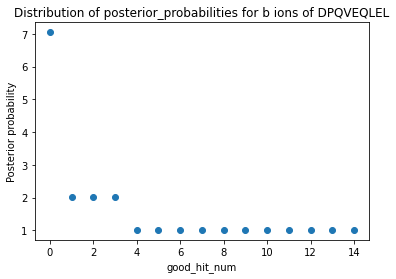

In [74]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = b_range, y = b_post_prob_array)
plt.title("Distribution of posterior_probabilities for b ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

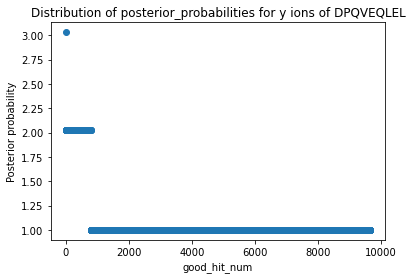

In [75]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = y_range, y = y_post_prob_array)
plt.title("Distribution of posterior_probabilities for y ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

# Seed Location

Want to know where the good seeds rank compared to the bad seeds when sorted by score and sorted by posterior probability

Bottom is going to be enumerated array while vertical will be the score or posterior probability. The graph will be colored red or green depending on true or not

In [76]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('post_prob', 'score', 'pid', 'prior'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_cluster_prob = []
b_bad_cluster_prob = []
y_good_indexes = []
y_bad_indexes = []
y_good_cluster_prob = []
y_bad_cluster_prob = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_cluster_prob.append(cluster.post_prob)
    else:
        b_bad_indexes.append(i)
        b_bad_cluster_prob.append(cluster.post_prob)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_cluster_prob.append(cluster.post_prob)
    else:
        y_bad_indexes.append(i)
        y_bad_cluster_prob.append(cluster.post_prob)
print('Done')

Done


Good hit found at: 0


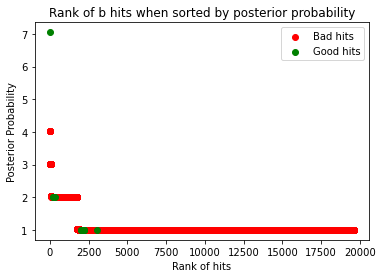

In [77]:
ion = 'b'
found = False
for i in range(0,50):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(b_good_indexes, b_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of b hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

Good hit found at: 15


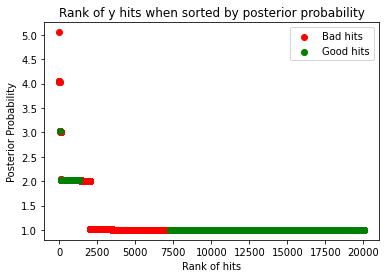

In [78]:
ion = 'y'
found = False
for i in range(0,50):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(y_good_indexes, y_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of y hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

In [56]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'post_prob', 'pid', 'prior'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_scores = []
b_bad_scores = []
y_good_indexes = []
y_bad_indexes = []
y_good_scores = []
y_bad_scores = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_scores.append(cluster.score)
    else:
        b_bad_indexes.append(i)
        b_bad_scores.append(cluster.score)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_scores.append(cluster.score)
    else:
        y_bad_indexes.append(i)
        y_bad_scores.append(cluster.score)
print('Done')

Done


Good hit found at: 0


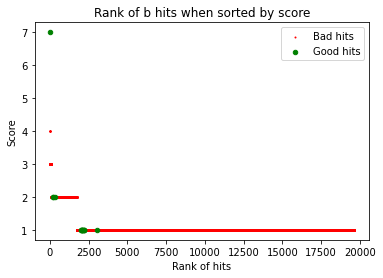

In [57]:
ion = 'b'
found = False
for i in range(0,50):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)    
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if found == False:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_scores, color = 'r', label = 'Bad hits', s=1)
plt.scatter(b_good_indexes, b_good_scores, color = 'g', label = 'Good hits', s=20)
plt.title('Rank of b hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

Good hit found at: 15


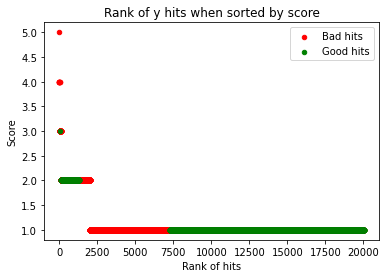

In [58]:
ion = 'y'
found = False
for i in range(0,50):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_scores, color = 'r', label = 'Bad hits', s = 20)
plt.scatter(y_good_indexes, y_good_scores, color = 'g', label = 'Good hits', s = 20)
plt.title('Rank of y hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

# Distribution of size of seq vs weight

In [29]:
size_array = []
weight_array = []
prot_size_array = []
prot_weight_array = []
for seq in correct_sequences:
    size_array.append(len(seq))
    weight_array.append(gen_spectra.get_precursor(seq))

Text(0, 0.5, 'Weight of result')

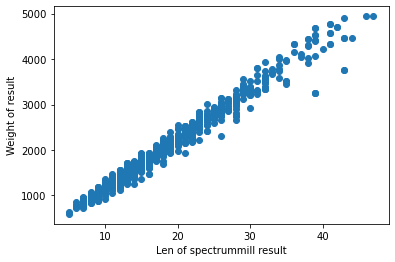

In [30]:
plt.scatter(size_array, weight_array)
plt.xlabel('Len of spectrummill result')
plt.ylabel('Weight of result')

Text(0, 0.5, 'Weight of Protein')

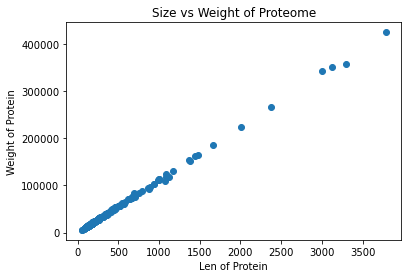

In [31]:
prot_size_array = []
prot_weight_array = []
for prot in db.proteins:
    target_prot = db.proteins[prot]
    if len(target_prot) != 0:
        target_prot = target_prot[0]
        seq = target_prot[1]
        prot_size_array.append(len(seq))
        prot_weight_array.append(gen_spectra.get_precursor(seq))
plt.scatter(prot_size_array, prot_weight_array)
plt.title('Size vs Weight of Proteome')
plt.xlabel('Len of Protein')
plt.ylabel('Weight of Protein')